In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
def train(models, train=True, plot=True):
    # define the target
    x = torch.linspace(-10, 10, 1000).unsqueeze(-1)
    target = (torch.cos(x)+x)

    # train loops
    losses = {model: [] for model in models.keys()}
    for name, model in models.items():
        opt = torch.optim.Adam(model.parameters(), lr=0.01)
        for i in (pbar:=tqdm(range(5000))):
            loss = ((model(x) -target)**2).mean()
            opt.zero_grad()
            loss.backward()
            opt.step()
            pbar.set_postfix({'rmse': loss.item()**0.5})
            losses[name].append(loss.item())

    if plot:
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(x, target, "k", label='target')
        for name, model in models.items():
            y = model(x).detach()
            plt.plot(x, y, label=f'{name} (rmse={losses[name][-1]**0.5:.2f})')
        plt.grid()
        plt.legend()
        plt.subplot(122)
        for (name), loss in losses.items():
            plt.semilogy(loss, label=name)
        plt.legend()
        plt.grid()
        plt.show()

In [3]:
from typing import Literal, Sequence


class MonotonicBlock(nn.Module):
    def __init__(self, in_dim:int, out_dim:int, activation=nn.Identity()):
        super().__init__()
        xavier_scale = (6/ (in_dim + out_dim)) ** 0.5
        self.W = nn.Parameter(xavier_scale*torch.rand((out_dim, in_dim)))
        self.b = nn.Parameter(torch.zeros(out_dim))
        self.act = activation

    def forward(self, x):
        W_pos, W_neg = self.W.clamp(min=0), self.W.clamp(max=0)
        x = self.act(x) @ W_pos.T + self.act(-x) @ W_neg.T + self.b
        return x

class MonotonicMLP(nn.Sequential):
    def __init__(
            self, 
            dims: Sequence[int], 
            activation:nn.Module, 
            output_activation=nn.Identity(),
        ):
        layers = [MonotonicBlock(dims[0], dims[1])]
        for in_dim, out_dim in zip(dims[1:-1], dims[2:], ):
            layers.append(MonotonicBlock(in_dim, out_dim, activation))
        layers.append(output_activation)
        super().__init__(*layers)

  0%|          | 0/5000 [00:00<?, ?it/s]

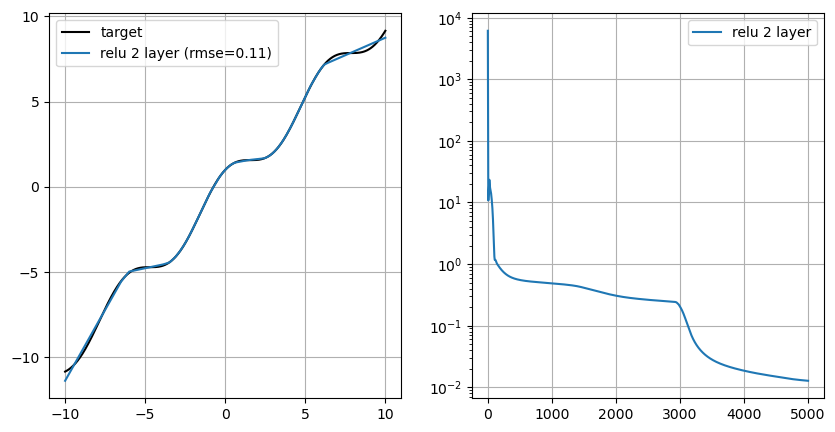

In [4]:
models = {
    # "relu 1 layer": MonotonicMLP(
    #     dims=(1, 256, 1), 
    #     activation=nn.ReLU(),
    # ),
    "relu 2 layer": MonotonicMLP(
        dims=(1, 256, 256, 1), 
        activation=nn.ReLU(), 
    )
}
train(models)